In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import time
import torch
from torch.autograd import Variable
from math import exp
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
import sys
sys.setrecursionlimit(10**9)
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim_skimage
from skimage.metrics import mean_squared_error

Device: cuda:0


# Model architectures and function deinitions

In [3]:
#Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = self.init_encoder()
        self.decoder = self.init_decoder()

    def init_encoder(self):
        """
        Initializes the encoder part of the autoencoder with 4 convolutional layers.
        """
        encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),  # Output: (16, 128, 128)
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # Output: (32, 64, 64)
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 32, 32)
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # Output: (128, 16, 16)
            nn.ReLU(True),
        )
        return encoder

    def init_decoder(self):
        """
        Initializes the decoder part of the autoencoder with 4 convolutional layers.
        """
        decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), # Output: (64, 32, 32)
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: (32, 64, 64)
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: (16, 128, 128)
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: (3, 256, 256)
            nn.Sigmoid()  # Use sigmoid to scale the output to [0,1]
        )
        return decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def fit(self, train_loader, validation_loader, epochs=10, learning_rate=1e-3, weight_decay=1e-5, loss_fn=nn.MSELoss(), verbose=False):
        optimizer = optim.Adam(self.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.to(device)
        results = []  # List to store outputs for visualization
        
        for epoch in range(epochs):
            self.train()  # Set model to training mode
            train_loss = 0.0
            for data in train_loader:
                inputs, targets = data
                inputs, targets = inputs.to(device), targets.to(device)

                optimizer.zero_grad()
                outputs = self(inputs)
                loss = loss_fn(outputs, targets)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            train_loss /= len(train_loader)

            if verbose:
                self.eval()  # Set the model to evaluation mode
                with torch.no_grad():  # Inference mode, gradient not computed
                    validation_loss = 0.0
                    for data in validation_loader:
                        inputs, targets = data
                        inputs, targets = inputs.to(device), targets.to(device)
                        outputs = self(inputs)
                        loss = loss_fn(outputs, targets)
                        validation_loss += loss.item()
                    validation_loss /= len(validation_loader)

                print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}")
            
            # Store outputs along with epoch number for visualization
            if epoch % 4 == 0:  # Adjust as per your requirement
                results.append((epoch, inputs.cpu(), outputs.cpu()))
                
        return outputs

    def visualize_reconstructions(self, outputs, n=5):
        """
        Visualizes original and reconstructed images.
        """
        for epoch, imgs, recons in outputs:
            plt.figure(figsize=(10, 2))
            for i in range(n):
                if i >= len(imgs): break
                plt.subplot(2, n, i + 1)
                plt.imshow(imgs[i].permute(1, 2, 0))
                plt.axis('off')
                
                plt.subplot(2, n, n + i + 1)
                plt.imshow(recons[i].permute(1, 2, 0))
                plt.axis('off')
            plt.suptitle(f'Epoch: {epoch}')
            plt.show()

        
#Predicting on a single image
def predict_single_image(model, image_path, model_path, device):
    global transform

    # Load the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Initialize the model and load the saved weights
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()

    # Predict
    with torch.no_grad():
        image = image.to(device)
        outputs = model(image)
        reconstructed_image = outputs.squeeze().cpu()
    return reconstructed_image  


#PSNR
def psnr_pytorch(img1, img2, data_range=1.0):
    mse = F.mse_loss(img1, img2)
    psnr_val = 20 * torch.log10(data_range / torch.sqrt(mse))
    return psnr_val.item()

#SSIM
def compute_mean_ssim(test_loader, model, device):
    model.eval()  # Set the model to evaluation mode
    total_ssim = 0.0
    total_count = 0

    with torch.no_grad():  # No need to track gradients
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)  # Generate predictions

            # Convert tensors to NumPy arrays
            for i in range(output.size(0)):
                img1 = output[i].cpu().detach().numpy().transpose(1, 2, 0)
                img2 = target[i].cpu().detach().numpy().transpose(1, 2, 0)

                # Ensure img1 and img2 are normalized properly if needed
                # Compute SSIM for each image pair
                ssim_val = ssim_skimage(img1, img2, multichannel=True, win_size=7)
                total_ssim += ssim_val
                total_count += 1

    mean_ssim = total_ssim / total_count
    return mean_ssim




#Evaluating model
def evaluate_model(model, test_loader, device, model_path):

    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()  # Set the model to evaluation mode
    total_mse, total_psnr = 0, 0
    avg_ssim = compute_mean_ssim(test_loader, model, device)
    criterion = nn.MSELoss()
    for batch in test_loader:
        inputs, targets = batch[0].to(device), batch[1].to(device)
        outputs = model(inputs)

        mse = criterion(outputs, targets).item()
        total_mse += mse
        
        
        # Compute PSNR and SSIM for each item in the batch and accumulate
        batch_psnr = psnr_pytorch(outputs, targets, data_range=1.0)
        total_psnr += batch_psnr * outputs.size(0)  # Multiply by batch size because psnr_pytorch returns the average

    # Calculate averages
    avg_mse = total_mse / len(test_loader.dataset)
    avg_psnr = total_psnr / len(test_loader.dataset)
    

    print(f"Test MSE: {avg_mse:.4f}, PSNR: {avg_psnr:.4f}, SSIM: {avg_ssim:.4f}")




#Dataset
class CelebADeblurDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            split (string): One of 'train', 'validation', 'test' to select the dataset split.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = os.path.join(root_dir, split)
        self.transform = transform
        self.blur_dir = os.path.join(self.root_dir, 'blur')
        self.sharp_dir = os.path.join(self.root_dir, 'sharp')
        self.image_files = os.listdir(self.blur_dir)[:50000]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        blur_img_path = os.path.join(self.blur_dir, self.image_files[idx])
        sharp_img_path = os.path.join(self.sharp_dir, self.image_files[idx])

        blur_image = Image.open(blur_img_path).convert('RGB')
        sharp_image = Image.open(sharp_img_path).convert('RGB')

        if self.transform:
            blur_image = self.transform(blur_image)
            sharp_image = self.transform(sharp_image)

        return blur_image, sharp_image

## Prediction of single image

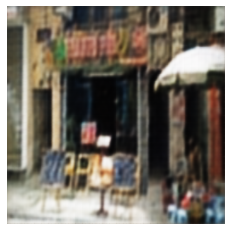

In [6]:
image_path = '/home/pdutta/myenv/dataset_occ/auto_test/textocr/test/blur/1.jpg'
model_path = '/home/pdutta/myenv/models/autoencoder_model_full8.pth'
model = Autoencoder().to(device)

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the images to 256x256
    transforms.ToTensor(),
])

recon = predict_single_image(model, image_path,model_path,device)
plt.imshow(recon.numpy().transpose(1, 2, 0))  # Convert CxHxW to HxWxC
plt.axis('off')
plt.show()


## Getting result on test set

#### Gopro dataset

In [23]:
# Define your transforms (adjust as necessary)
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the images to 256x256
    transforms.ToTensor(),
])

# # Instantiate your dataset
root_dir = '/home/pdutta/myenv/dataset_occ/auto_test/gopro'
test_dataset = CelebADeblurDataset(root_dir=root_dir, split='test', transform=transform)

# Load the datasets into DataLoader for efficient batching and shuffling
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
evaluate_model(model, test_loader, device, model_path)

Test MSE: 0.0001, PSNR: 23.7087, SSIM: 0.8146


#### Textocr dataset

In [24]:
# # Instantiate your dataset
root_dir = '/home/pdutta/myenv/dataset_occ/auto_test/textocr'
test_dataset = CelebADeblurDataset(root_dir=root_dir, split='test', transform=transform)

# Load the datasets into DataLoader for efficient batching and shuffling
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
evaluate_model(model, test_loader, device, model_path)

Test MSE: 0.0001, PSNR: 23.9223, SSIM: 0.8338


#### Helen Dataset

In [25]:
# # Instantiate your dataset
root_dir = '/home/pdutta/myenv/dataset_occ/auto_test/Helen'
test_dataset = CelebADeblurDataset(root_dir=root_dir, split='test', transform=transform)

# Load the datasets into DataLoader for efficient batching and shuffling
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
evaluate_model(model, test_loader, device, model_path)

Test MSE: 0.0000, PSNR: 27.1433, SSIM: 0.8933
